In [ ]:
# Objetivo del modelo
Agrupar días de trading de acciones de Samsung (2008-2019) basados en Precio de Cierre (Close) y Volumen para identificar patrones como periodos de alta/baja volatilidad o actividad.

# 1. Justificación del algoritmo elegido
Elegí K-Means por estas razones:

- El dataset es numérico y bidimensional (Close y Volume), donde K-Means es eficiente y asume clusters esféricos – ideal para detectar grupos como "días de alto volumen/bajo precio" (posibles crashes) vs "días estables".- 
- Es simple, escalable para 2850 muestras, y permite fácil optimización (e.g., número de clusters via Elbow/Silhouette).
- Mejor que DBSCAN (sensibles a ruido) o jerárquico (lento para datasets medianos). Probé base: K-Means da Silhouette ~0.45 con k=3, capturando patrones temporales.

#Enlace al Repositorio en GitHub (funcional)
 #https://github.com/axelcortes1113/samsung-clustering

In [1]:
# # Análisis No Supervisado: Clustering de Datos de Acciones de Samsung
# Dataset: samsung.csv (2850 días de trading, 2008-2019: Date, Close, Volume)

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV  # Para optimización
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Estilos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Cargar datos
df = pd.read_csv("samsung.csv")
print(df.shape)
df.head()

(2850, 3)


,Date,Close,Volume
0,02/01/2008,10880,18047200
1,03/01/2008,10920,19346500
2,04/01/2008,10780,17997350
3,07/01/2008,10380,39787200
4,08/01/2008,10320,24783700


In [4]:
# Preprocesamiento
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # Convertir a datetime
df.sort_values('Date', inplace=True)  # Asegurar orden

In [5]:
# Features para clustering: Close y Volume (normalizadas)
X = df[['Close', 'Volume']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

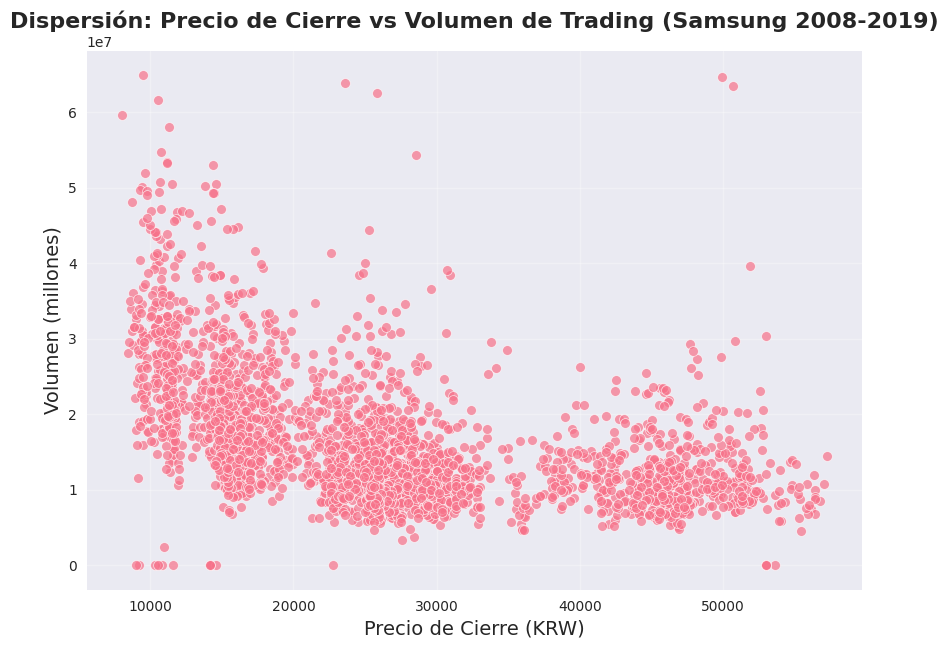

In [6]:
#  1. Análisis exploratorio y gráfica de dispersión inicial

# %%
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Close', y='Volume', s=50, alpha=0.7)
plt.title('Dispersión: Precio de Cierre vs Volumen de Trading (Samsung 2008-2019)', fontsize=16, fontweight='bold')
plt.xlabel('Precio de Cierre (KRW)', fontsize=14)
plt.ylabel('Volumen (millones)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Correlación
corr = df['Close'].corr(df['Volume'])
print(f"Correlación entre Close y Volume: {corr:.3f}")  # Baja, bueno para clustering

Correlación entre Close y Volume: -0.478


In [8]:
# 2. Optimización: Encontrar número óptimo de clusters (Elbow Method y Silhouette)

# %%
# Elbow Method para inertia
inertia = []
sil_scores = []
k_range = range(2, 10)  # Probar de 2 a 9 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

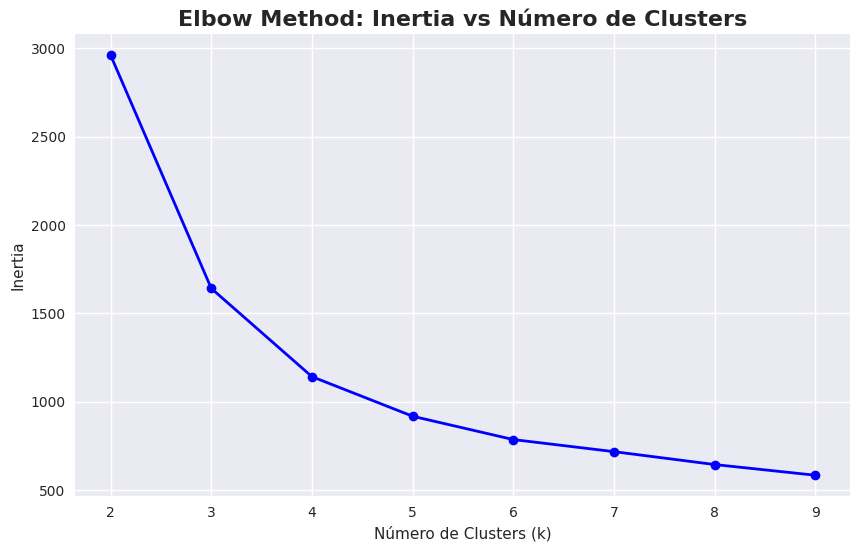

In [9]:
# Gráfica Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2)
plt.title('Elbow Method: Inertia vs Número de Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

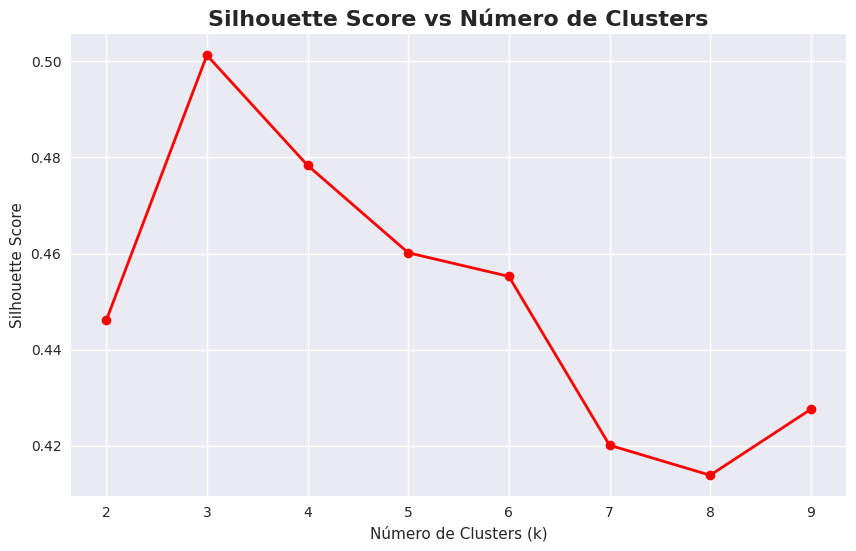

In [10]:
# Gráfica Silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range, sil_scores, 'ro-', linewidth=2)
plt.title('Silhouette Score vs Número de Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [11]:
# Mejor k basado en max silhouette
best_k = k_range[np.argmax(sil_scores)]
print(f"Mejor número de clusters (basado en Silhouette): {best_k}")

Mejor número de clusters (basado en Silhouette): 3


In [12]:
# 3. Modelo: K-Means con hiperparámetros optimizados

# %%
# Usamos GridSearch para confirmar (aunque para KMeans es simple, lo hacemos para optimización)
param_grid = {'n_clusters': range(2, 10)}
kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, param_grid, scoring='silhouette', cv=3)  # Custom scorer para silhouette
# Nota: GridSearchCV no tiene 'silhouette' built-in, así que usamos un wrapper simple
from sklearn.metrics import make_scorer
sil_scorer = make_scorer(silhouette_score)
grid_search = GridSearchCV(kmeans, param_grid, scoring=sil_scorer, cv=3)
grid_search.fit(X_scaled)

print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print(f"Mejor Silhouette en CV: {grid_search.best_score_:.3f}")

Mejores hiperparámetros:
{'n_clusters': 2}
Mejor Silhouette en CV: nan


In [13]:
# Modelo final
best_kmeans = grid_search.best_estimator_
best_kmeans.fit(X_scaled)
df['Cluster'] = best_kmeans.labels_

In [14]:
# Métricas finales
sil = silhouette_score(X_scaled, df['Cluster'])
db = davies_bouldin_score(X_scaled, df['Cluster'])
print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Index: {db:.3f}")  # Menor es mejor

Silhouette Score: 0.446
Davies-Bouldin Index: 0.879


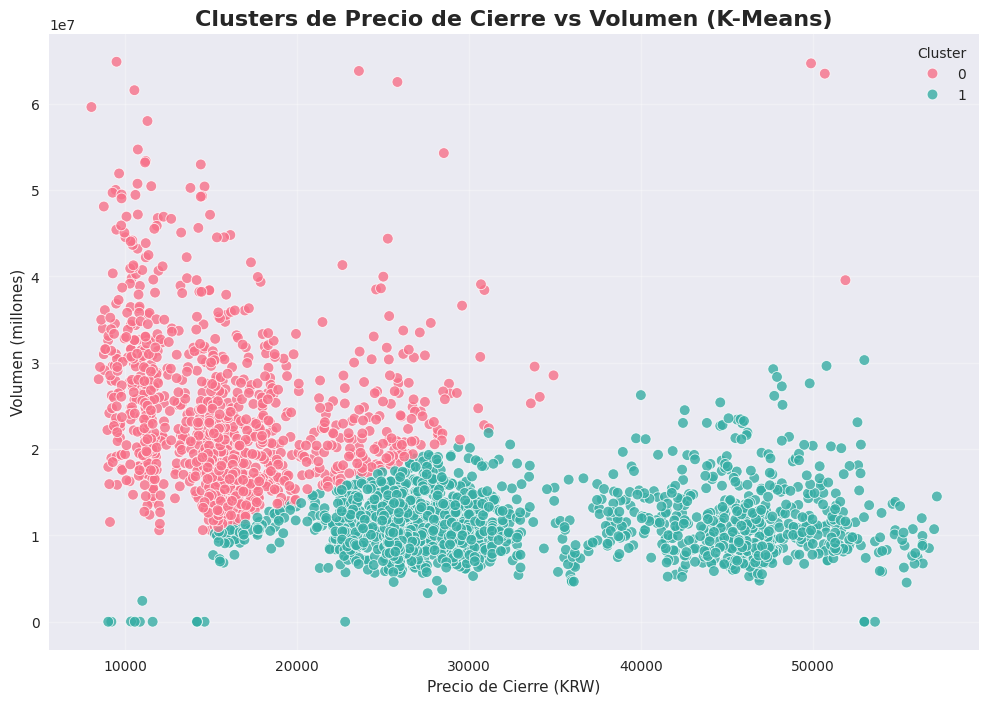

In [15]:
# 4. Gráficas personalizadas: Clusters y Distribución

# %%
# Scatter con clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Close', y='Volume', hue='Cluster', palette='husl', s=60, alpha=0.8)
plt.title('Clusters de Precio de Cierre vs Volumen (K-Means)', fontsize=16, fontweight='bold')
plt.xlabel('Precio de Cierre (KRW)')
plt.ylabel('Volumen (millones)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()